## Feature Selection

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

### Pré-processamento

#### Baixa sos dados

In [2]:
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60302  100 60302    0     0   170k      0 --:--:-- --:--:-- --:--:--  170k


#### Carrega os dados

In [3]:
titanic = pd.read_csv('titanic.csv')

titanic.columns = ['IdPassageiro',
                   'Sobreviveu?', 
                   'Classe',
                   'Nome',
                   'Sexo',
                   'Idade',
                   'Irmãos/Cônjuge',
                   'Pais/Crianças',
                   'Bilhete',
                   'Tarifa',
                   'Cabine',
                   'Embarque']

titanic = titanic.set_index('IdPassageiro')
titanic.drop(['Nome','Bilhete','Cabine'], axis=1, inplace = True)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque
IdPassageiro,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


#### Missing Values

In [4]:
titanic.isna().sum()

Sobreviveu?         0
Classe              0
Sexo                0
Idade             177
Irmãos/Cônjuge      0
Pais/Crianças       0
Tarifa              0
Embarque            2
dtype: int64

In [5]:
titanic['Idade'].fillna(titanic['Idade'].mean(), inplace=True)
titanic['Embarque'].fillna(titanic['Embarque'].mode()[0], inplace=True)
titanic.isna().sum()

Sobreviveu?       0
Classe            0
Sexo              0
Idade             0
Irmãos/Cônjuge    0
Pais/Crianças     0
Tarifa            0
Embarque          0
dtype: int64

In [6]:
titanic.describe()

,Sobreviveu?,Classe,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Discretização de Dados Numéricos

#### Correlação entre Idade e Sobreviventes

In [7]:
titanic['Idade'].corr(titanic['Sobreviveu?'])

-0.06980851528714314

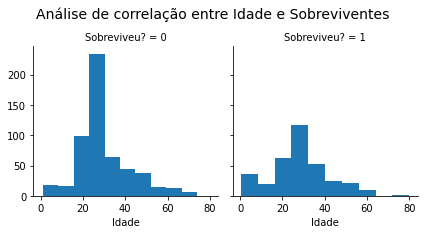

In [8]:
g = sns.FacetGrid(titanic, col='Sobreviveu?')
g.map(plt.hist, 'Idade', bins=10)
plt.suptitle('Análise de correlação entre Idade e Sobreviventes', y=1.07, size=14)
plt.show()

In [9]:
titanic['IdadeDisc'] = pd.cut(titanic['Idade'], 
                              bins=[0, 15, 25, 60, 80], 
                              labels=['Criança', 'Jovem', 'Adulto', 'Idoso'])

titanic.tail()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc
IdPassageiro,,,,,,,,,
887,0,2,male,27.000000,0,0,13.00,S,Adulto
888,1,1,female,19.000000,0,0,30.00,S,Jovem
889,0,3,female,29.699118,1,2,23.45,S,Adulto
890,1,1,male,26.000000,0,0,30.00,C,Adulto
891,0,3,male,32.000000,0,0,7.75,Q,Adulto


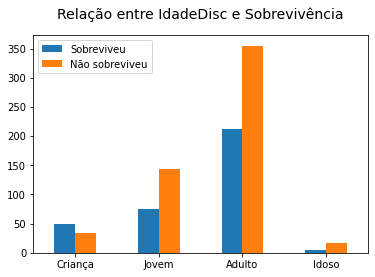

In [10]:
survived = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('IdadeDisc')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived, 'Não sobreviveu': not_survived}, index=index)

ax = df.plot.bar(rot=0)
plt.title('Relação entre IdadeDisc e Sobrevivência', y=1.05, size=14)
plt.show()

#### Correlação entre Tarifa e Sobrevivência

In [11]:
titanic['Tarifa'].corr(titanic['Sobreviveu?'])

0.2573065223849625

#### Intervalos para deixar a distribuição + equilibrada

In [12]:
intervals = pd.qcut(titanic['Tarifa'], 3).astype(str).unique()
intervals

array(['(-0.001, 8.662]', '(26.0, 512.329]', '(8.662, 26.0]'],
      dtype=object)

In [13]:
titanic['Tipo_tarifa'] = pd.qcut(titanic['Tarifa'], 3).astype(str).map({intervals[0]: 'Barato', 
                                                                        intervals[1]: 'Medio', 
                                                                        intervals[2]: 'Caro'}).astype(str)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_tarifa
IdPassageiro,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Jovem,Barato
2,1,1,female,38.0,1,0,71.2833,C,Adulto,Medio
3,1,3,female,26.0,0,0,7.9250,S,Adulto,Barato
4,1,1,female,35.0,1,0,53.1000,S,Adulto,Medio
5,0,3,male,35.0,0,0,8.0500,S,Adulto,Barato


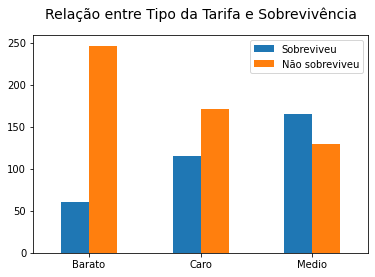

In [14]:
survived = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_tarifa')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('Tipo_tarifa')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_tarifa')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived, 'Não sobreviveu': not_survived}, index=index)

ax = df.plot.bar(rot=0)
plt.title('Relação entre Tipo da Tarifa e Sobrevivência', y=1.05, size=14)
plt.show()

### Transformação de Dados Categóricos

#### Mapeamento

In [15]:
titanic['Sexo'] = titanic['Sexo'].map({'female': 0, 'male': 1}).astype(int)
titanic['Embarque'] = titanic['Embarque'].map({'S': 0, 'C': 1, 'Q':2}).astype(int)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_tarifa
IdPassageiro,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,Jovem,Barato
2,1,1,0,38.0,1,0,71.2833,1,Adulto,Medio
3,1,3,0,26.0,0,0,7.9250,0,Adulto,Barato
4,1,1,0,35.0,1,0,53.1000,0,Adulto,Medio
5,0,3,1,35.0,0,0,8.0500,0,Adulto,Barato


#### One-hot Encoding

In [16]:
dummy = pd.get_dummies(titanic['IdadeDisc'])
titanic= pd.concat([titanic, dummy], axis=1)

dummy = pd.get_dummies(titanic['Tipo_tarifa'])
titanic = pd.concat([titanic, dummy], axis=1)

titanic.drop(['IdadeDisc', 'Tipo_tarifa'], axis=1, inplace=True)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
IdPassageiro,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0,1,0,0,1,0,0
2,1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0,0,1
3,1,3,0,26.0,0,0,7.9250,0,0,0,1,0,1,0,0
4,1,1,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,1
5,0,3,1,35.0,0,0,8.0500,0,0,0,1,0,1,0,0


### Normalização Min-Max  [0,1]